<a href="https://colab.research.google.com/github/indiegolab/nlp_class/blob/master/text_classification_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 텍스트 분류 with RNN
Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## 설정

In [1]:
# 텐서플로 2.0 
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow_datasets as tfds
import tensorflow as tf

TensorFlow 2.x selected.


In [9]:
# print(tf.VERSION)
!pip show tensorflow

Name: tensorflow
Version: 2.0.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /tensorflow-2.0.0/python3.6
Requires: termcolor, grpcio, tensorboard, wheel, astor, tensorflow-estimator, keras-preprocessing, six, absl-py, opt-einsum, gast, protobuf, google-pasta, wrapt, keras-applications, numpy
Required-by: stable-baselines, magenta, fancyimpute


Import `matplotlib` and create a helper function to plot graphs:

In [0]:
# history를 바탕으로 plot 그래프 그리기 함수 작성
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## 인풋 파이프라인 설정


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

IMDB 영화 리뷰 데이터셋: 이진분류, 모든 리뷰에는 긍정/부정 레이블이 달려있다.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets).


In [0]:
# TF 데이터셋 보기
!pip install -q tensorflow tensorflow-datasets matplotlib

In [0]:
# !pip install tensorflow==2.0.0-alpha0

     |████████████████████████████████| 79.9MB 124kB/s 
     |████████████████████████████████| 3.0MB 51.4MB/s 
     |████████████████████████████████| 419kB 59.4MB/s 
  Found existing installation: tensorflow 2.0.0
    Uninstalling tensorflow-2.0.0:
      Successfully uninstalled tensorflow-2.0.0


In [10]:
### mnist 예시/ 실행이 안됨.
import tensorflow as tf
import tensorflow_datasets as tfds

# tfds works in both Eager and Graph modes

# 텐서플로 2.0에서 즉시 실행은 기본으로 활성화되어 있습니다.
# tf.enable_eager_execution()

# See available datasets
print(tfds.list_builders())

# Construct a tf.data.Dataset
dataset = tfds.load(name="mnist", split=tfds.Split.TRAIN)

# Build your input pipeline
dataset = dataset.shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
for features in dataset.take(1):
  image, label = features["image"], features["label"]

AttributeError: ignored

In [0]:
# Installation Start
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

In [12]:
# imdb_reviews 데이터 가져오기

dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
# train, test 데이터 할당
train_dataset, test_dataset = dataset['train'], dataset['test']

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


 The dataset `info` includes the encoder (a `tfds.features.text.SubwordTextEncoder`).

In [0]:
encoder = info.features['text'].encoder

In [14]:
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.

In [19]:
# 텍스트 인코더 예시
## 문자열을 인덱스 숫자로 바꾼다.
# sample_string = '안녕 텐서플로우.'
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [0]:
assert original_string == sample_string

In [17]:
# 각 인덱스와 함께 디코딩하면서 각 문자열이 할당된 인덱스를 보여줌.
for index in encoded_string:
  print ('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## 훈련을 위한 데이터 준비

Next create batches of these encoded strings. Use the `padded_batch` method to zero-pad the sequences to the length of the longest string in the batch:


다음 이러한 인코드 된 문자열 묶음을 만들어 낸다.
패딩된_batch 방법을 사용하여 배치에서 가장 긴 문자열 길이로 시퀀스를 제로 패딩하십시오.

In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [0]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

## 모델 생성

Build a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.


모델을 빌드하고 임베드 레이어로 시작하십시오. 임베드 레이어는 단어 당 하나의 벡터를 저장합니다. 호출되면 단어 인덱스 시퀀스를 벡터 시퀀스로 변환합니다. 이 벡터는 훈련 가능합니다. 충분한 데이터에 대한 훈련 후 비슷한 의미를 가진 단어는 종종 비슷한 벡터를 갖습니다.

.  

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

이 인덱스 조회는 one-hot 인코딩 된 벡터를 tf.keras.layers.Dense 레이어를 통해 전달하는 동등한 작업보다 훨씬 효율적입니다.

.  
 
A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

RNN (Recurrent Neural Network)은 요소를 반복하여 시퀀스 입력을 처리합니다. RNN은 출력을 한 단계에서 입력으로 전달한 다음, 다음 단계로 전달합니다.

.  


The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.
tf.keras.Sequential 


tf.keras.layers.Bidirectional 래퍼도 RNN 레이어와 함께 사용할 수 있습니다. 이는 RNN 계층을 통해 입력을 앞뒤로 전파 한 다음 출력을 연결합니다. 이는 RNN이 장거리 종속성을 학습하는 데 도움이됩니다.




In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Compile the Keras model to configure the training process:

Keras 모델을 컴파일하여 교육 프로세스를 구성하십시오.

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## 모델 훈련
Train the model
* history기능 사용
    - 매 에폭 마다의 훈련 손실값 (loss)
    - 매 에폭 마다의 훈련 정확도 (acc)
    - 매 에폭 마다의 검증 손실값 (val_loss)
    - 매 에폭 마다의 검증 정확도 (val_acc)

- 로그의 수치들은 학습이 제대로 되고 있는 지, 학습을 그만할 지 등을 판단하는 중요한 기준이 된다.

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 63s 161ms/step - loss: 0.6758 - accuracy: 0.5736 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 56s 144ms/step - loss: 0.3687 - accuracy: 0.8488 - val_loss: 0.3445 - val_accuracy: 0.8615
Epoch 3/10
391/391 [==============================] - 56s 142ms/step - loss: 0.2533 - accuracy: 0.9066 - val_loss: 0.3258 - val_accuracy: 0.8703
Epoch 4/10
391/391 [==============================] - 56s 143ms/step - loss: 0.2105 - accuracy: 0.9257 - val_loss: 0.3085 - val_accuracy: 0.8740
Epoch 5/10
391/391 [==============================] - 56s 143ms/step - loss: 0.1831 - accuracy: 0.9380 - val_loss: 0.3322 - val_accuracy: 0.8714
Epoch 6/10
391/391 [==============================] - 56s 143ms/step - loss: 0.1619 - accuracy: 0.9471 - val_loss: 0.3433 - val_accuracy: 0.8734
Epoch 7/10
391/391 [==============================] - 56s 143ms/step - loss: 0.1415 - accuracy: 0.9551 - val_loss: 0.3779 

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 22s 57ms/step - loss: 0.4533 - accuracy: 0.8513
Test Loss: 0.4533025862463295
Test Accuracy: 0.8513200283050537


The above model does not mask the padding applied to the sequences. This can lead to skew if trained on padded sequences and test on un-padded sequences. Ideally you would [use masking](../../guide/keras/masking_and_padding) to avoid this, but as you can see below it only have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.


위의 모델은 시퀀스에 적용된 패딩을 가리지 않습니다. 패딩 된 시퀀스를 학습하고 패딩되지 않은 시퀀스를 테스트하면 왜곡 될 수 있습니다. 이상적으로는이를 피하기 위해 마스킹을 사용하지만 아래에서 볼 수 있듯이 출력에는 약간의 영향 만 미칩니다.

예측이> = 0.5 인 경우, 양수이고 그렇지 않으면 음수입니다.



In [0]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [0]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [28]:
# 패딩없이 샘플 텍스트 예측

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
# sample_pred_text = ('The movie was cool. The animation and the graphics '
#                     'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.33549932]]


In [29]:
# 패딩 적용하고 샘플 텍스트 예측
## 패딩 적용시 정확도가 조금 올라가는 것을 확실할 수 있다.(?)

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.35720882]]


- 그래프를 통해 보면 훈련 정확도/손실과 검증 정확도/손실의 차이를 더 직관적으로 볼 수 있다.

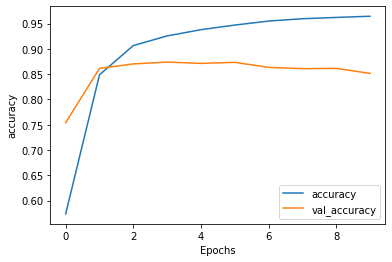

In [30]:
# 정확도
plot_graphs(history, 'accuracy')

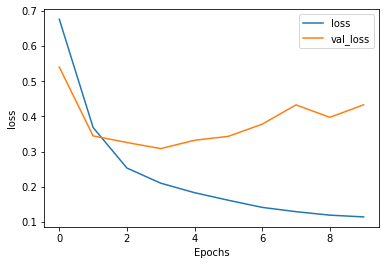

In [33]:
# 손실
plot_graphs(history, 'loss')

## 2개 혹은 그 이상의 LSTM 층 쌓기
- Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

Keras 반복 레이어에는`return_sequences` 생성자 인수로 제어되는 두 가지 사용 가능한 모드가 있습니다.

.  


* Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
* Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).


* 각 타임 스텝 (`batch_size, timesteps, output_features '모양의 3D 텐서)에 대한 전체 연속 출력 시퀀스를 반환합니다.
* 각 입력 시퀀스에 대한 마지막 출력 만 반환합니다 (형태의 2D 텐서 (batch_size, output_features)).

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [36]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 103s 263ms/step - loss: 0.6970 - accuracy: 0.5339 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 97s 248ms/step - loss: 0.6860 - accuracy: 0.5443 - val_loss: 0.7262 - val_accuracy: 0.4901
Epoch 3/10
391/391 [==============================] - 97s 247ms/step - loss: 0.6343 - accuracy: 0.6445 - val_loss: 0.6886 - val_accuracy: 0.6042
Epoch 4/10
391/391 [==============================] - 96s 246ms/step - loss: 0.5699 - accuracy: 0.7250 - val_loss: 0.5587 - val_accuracy: 0.7245
Epoch 5/10
391/391 [==============================] - 97s 247ms/step - loss: 0.5191 - accuracy: 0.7708 - val_loss: 0.5209 - val_accuracy: 0.7568
Epoch 6/10
391/391 [==============================] - 97s 247ms/step - loss: 0.4511 - accuracy: 0.8193 - val_loss: 0.5351 - val_accuracy: 0.7417
Epoch 7/10
391/391 [==============================] - 98s 250ms/step - loss: 0.4145 - accuracy: 0.8340 - val_loss: 0.4524

In [37]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 38s 97ms/step - loss: 0.5416 - accuracy: 0.7444
Test Loss: 0.5416223622496475
Test Accuracy: 0.7443600296974182


In [46]:
# # 패딩없이 샘플 텍스트 예측

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.41338694]]


In [47]:
# 패딩 적용하고 샘플 텍스트 예측

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.48886552]]


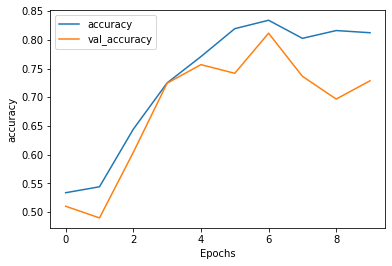

In [40]:
plot_graphs(history, 'accuracy')

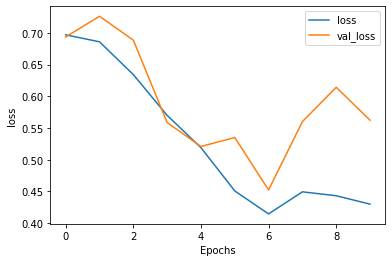

In [41]:
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).
